### Import Necessary Libraries

In [1]:
import itertools
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string 
import time

from bs4 import BeautifulSoup
from collections import Counter
from itertools import chain
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
from pandas.io.json import json_normalize
from pprint import pprint
from recipe_scrapers import scrape_me

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [19]:
# Load in DataFrame of Recipe Information
df = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/final.csv')
# drop unwanted columns
df_small = df.drop(columns=['ings_cleaned','ings_str', 'text', 'final', 'txt', 'try','finally',
                 'calories_g', 'fat_g', 'carbohydrates_g', 'protein_g', 'cholesterol_mg', 'sodium_mg'])

In [18]:
# Load in DataFrame with Continuous Data
nutri = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/nutri_facts.csv')

In [17]:
# Load in DataFrame with Instructions and Images
inst = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/CSV Files/img_ins.csv')

In [12]:
# Join all DataFrames on name
from functools import reduce

dfs = [df_small, nutri, inst]

df_final = reduce(lambda left,right: pd.merge(left,right,on='name'), dfs)

In [ ]:
df.to_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/6k_cleaner.csv',index=False)

In [15]:
cols = df_final.columns.to_list()

In [21]:
new_cols = ['name', 'ingredients','instructions','ings_str1','cleaned_ings','calories_g',
            'fat_g', 'carbohydrates_g','protein_g','cholesterol_mg','sodium_mg','prep_time',
            'cook_time','total_time','avg_rating','image']

In [23]:
df_final = df_final[new_cols]

In [24]:
df_final.head()

,name,ingredients,instructions,ings_str1,cleaned_ings,calories_g,fat_g,carbohydrates_g,protein_g,cholesterol_mg,sodium_mg,prep_time,cook_time,total_time,avg_rating,image
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']","In a Dutch oven, cook sausage, ground beef, onion, and garlic over medium heat until well browned. Stir in crushed tomatoes, tomato paste, tomato sauce, and water. Season with sugar, basil, fennel seeds, Italian seasoning, 1 teaspoon salt, pepper, and 2 tablespoons parsley. Simmer, covered, for about 1 1/2 hours, stirring occasionally.\nBring a large pot of lightly salted water to a boil. Cook lasagna noodles in boiling water for 8 to 10 minutes. Drain noodles, and rinse with cold water. In a mixing bowl, combine ricotta cheese with egg, remaining parsley, and 1/2 teaspoon salt.\nPreheat oven to 375 degrees F (190 degrees C).\nTo assemble, spread 1 1/2 cups of meat sauce in the bottom of a 9x13 inch baking dish. Arrange 6 noodles lengthwise over meat sauce. Spread with one half of the ricotta cheese mixture. Top with a third of mozzarella cheese slices. Spoon 1 1/2 cups meat sauce over mozzarella, and sprinkle with 1/4 cup Parmesan cheese. Repeat layers, and top with remaining mozzarella and Parmesan cheese. Cover with foil: to prevent sticking, either spray foil with cooking spray, or make sure the foil does not touch the cheese.\nBake in preheated oven for 25 minutes. Remove foil, and bake an additional 25 minutes. Cool for 15 minutes before serving.\n","sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",448.0,21.3,36.5,29.7,82,1400.0,30 m,2 h 30 m,195.0,4.80,https://images.media-allrecipes.com/userphotos/560x315/3359675.jpg
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']","Season both sides of pork chops with paprika, salt, and pepper.\nHeat a large skillet over medium-high heat; add 2 tablespoons butter. Sear pork chops until golden brown and no longer pink in the center, 2 to 4 minutes per side. Remove pork chops from the skillet and set aside.\nMelt remaining butter in the same skillet over medium-high heat. Add mushrooms and cook until golden and excess moisture evaporates, about 5 minutes. Add garlic and mustard; cook until garlic is fragrant, about 1 minute.\nAdd flour to the skillet, stirring to remove any lumps. Slowly add beef broth, whisking until incorporated. Season with salt and pepper. Reduce heat to medium and simmer, stirring often, until sauce thickens, about 5 minutes. Check for seasoning again.\nReturn pork chops to the skillet and cook until heated through, about 1 minute. Serve hot.\n","pork chops, paprika, butter, mushrooms, garlic, 

In [14]:
bagofwords = []
for words in df['text'].values:
    bagofwords.append(words.split(' '))

In [31]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = []
for val in df.text.values:
    doc.append(nlp(val))

In [32]:
len(doc)

5538

In [36]:
df.head()

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings,text,final,txt,calories_g,fat_g,carbohydrates_g,protein_g,cholesterol_mg,sodium_mg,try,finally
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",195.0,4.80,"['sweet Italian sausage', 'lean ground beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",sweet Italian sausage lean ground beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leaves fennel seeds Italian seasoning black pepper parsley lasagna noodles ricotta cheese eggs mozzarella cheese Parmesan cheese,"sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",italian sausage beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese egg mozzarella cheese parmesan cheese,"['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']","['italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leave', 'fennel seed', 'italian season', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'egg', 'mozzarella cheese', 'parmesan cheese']",448.0,21.3,36.5,29.7,82,1400.0,"['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']",30.0,4.61,"['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'all-purpose flour', 'beef broth']",pork chops paprika butter mushrooms garlic Dijon mustard all-purpose flour beef broth,"pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth","['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon

In [37]:
raw_df = df.drop(columns=['ings_cleaned', 'ings_str','ings_str1','final', 'txt'])

In [46]:
raw_df['tokens'] = doc

In [44]:
raw_df.drop(columns=['cleaned_ings','txt'],inplace=True)

In [53]:
df.head()

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings,text,final,txt,calories_g,fat_g,carbohydrates_g,protein_g,cholesterol_mg,sodium_mg,try,finally
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",195.0,4.80,"['sweet Italian sausage', 'lean ground beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",sweet Italian sausage lean ground beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leaves fennel seeds Italian seasoning black pepper parsley lasagna noodles ricotta cheese eggs mozzarella cheese Parmesan cheese,"sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",italian sausage beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese egg mozzarella cheese parmesan cheese,"['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']","['italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leave', 'fennel seed', 'italian season', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'egg', 'mozzarella cheese', 'parmesan cheese']",448.0,21.3,36.5,29.7,82,1400.0,"['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']",30.0,4.61,"['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'all-purpose flour', 'beef broth']",pork chops paprika butter mushrooms garlic Dijon mustard all-purpose flour beef broth,"pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth","['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon

In [188]:
def keywords_recommendation(keywords, number_of_hits):
    query_doc_bow = dictionary.doc2bow(processed_keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our movie and every other movie. 
    #So the length is the number of movies we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=df.name.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
    # i.e. most similar movies

    # Print the top matching movies
    print("Our top %s most similar recipes for the keywords %s are:" %(number_of_hits, keywords))
    for idx, (movie,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d '%s' with a similarity score of %.3f" %(idx+1, movie, score))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_recommender(keywords, number_of_hits=5):
    query_doc_bow = dictionary.doc2bow(processed_keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie
    
    movie_index = movies[movies.primaryTitle == movie_title].index.values[0]

    cosines = []
    for i in range(len(vectors)):
        vector_list = [vectors[movie_index], vectors[i]]
        cosines.append(cosine_similarity(vector_list)[0,1])

    cosines = pd.Series(cosines)
    index = cosines.nlargest(number_of_hits+1).index

    matches = movies.loc[index]
    for match,score in zip(matches['primaryTitle'][1:],cosines[index][1:]):
        print(match,score )

In [119]:
keywords[0]

['italian',
 'sausage',
 'beef',
 'onion',
 'garlic',
 'tomatoes',
 'tomato',
 'paste',
 'tomato',
 'sauce',
 'water',
 'white',
 'sugar',
 'basil',
 'leave',
 'fennel',
 'seed',
 'italian',
 'season',
 'black',
 'pepper',
 'parsley',
 'lasagna',
 'noodles',
 'ricotta',
 'cheese',
 'egg',
 'mozzarella',
 'cheese',
 'parmesan',
 'cheese']

In [90]:
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

In [101]:
clean_keys = []
for keys in keywords:
    clean_keys.append(Remove(keys))

In [106]:
clean_keys[0]

['italian',
 'sausage',
 'beef',
 'onion',
 'garlic',
 'tomatoes',
 'tomato',
 'paste',
 'sauce',
 'water',
 'white',
 'sugar',
 'basil',
 'leave',
 'fennel',
 'seed',
 'season',
 'black',
 'pepper',
 'parsley',
 'lasagna',
 'noodles',
 'ricotta',
 'cheese',
 'egg',
 'mozzarella',
 'parmesan']

In [159]:
all_words = df['text'].tolist()

In [195]:
all_words[0].split()

['italian',
 'sausage',
 'beef',
 'onion',
 'garlic',
 'tomatoes',
 'tomato',
 'paste',
 'tomato',
 'sauce',
 'water',
 'white',
 'sugar',
 'basil',
 'leave',
 'fennel',
 'seed',
 'italian',
 'season',
 'black',
 'pepper',
 'parsley',
 'lasagna',
 'noodles',
 'ricotta',
 'cheese',
 'egg',
 'mozzarella',
 'cheese',
 'parmesan',
 'cheese']

In [166]:
every_ing = []
for words in all_words:
    every_ing.append(Remove(words.split()))

In [178]:
position = count_vectorizer.vocabulary_['chicken']
# tf_idfmatrix[:, position] *= 2.0

NameError: name 'count_vectorizer' is not defined

In [199]:
df.head()

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings,text,final,txt,calories_g,fat_g,carbohydrates_g,protein_g,cholesterol_mg,sodium_mg,try,finally
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",195.0,4.80,"['sweet Italian sausage', 'lean ground beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",sweet Italian sausage lean ground beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leaves fennel seeds Italian seasoning black pepper parsley lasagna noodles ricotta cheese eggs mozzarella cheese Parmesan cheese,"sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",italian sausage beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese egg mozzarella cheese parmesan cheese,"['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']","['italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leave', 'fennel seed', 'italian season', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'egg', 'mozzarella cheese', 'parmesan cheese']",448.0,21.3,36.5,29.7,82,1400.0,"['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']",30.0,4.61,"['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'all-purpose flour', 'beef broth']",pork chops paprika butter mushrooms garlic Dijon mustard all-purpose flour beef broth,"pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth","['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon

In [200]:
keywords = df['ings_str'].tolist()
keywords = [word_tokenize(keyword.lower()) for keyword in keywords]
keywords = [no_commas(kw) for kw in keywords]

In [201]:
from gensim.corpora.dictionary import Dictionary
dictionary_keywords = Dictionary(keywords)
corpus = [dictionary_keywords.doc2bow(keyword) for keyword in keywords]

In [202]:
from collections import defaultdict
import itertools
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)

# Print the top 20 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:5]:
    print(dictionary_keywords.get(word_id), word_count)

pepper 3452
cheese 2825
garlic 2808
oil 2650
onion 2466


In [211]:
def keywords_recommendation(keywords, number_of_hits):
    query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the recipe name and it's tf-idf value for the recipe

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our recipe and every other recipe. 
    #So the length is the number of recipe we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=df.name.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
    # i.e. most similar recipes

    # Print the top matching eecipes
    print("Our top %s most similar recipes for the keywords %s are:" %(number_of_hits, keywords))
    for idx, (recipe,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d '%s' with a similarity score of %.3f" %(idx+1, recipe, score))

In [221]:
keywords_recommendation(['lobster','lemon','crab'],8)

Our top 8 most similar recipes for the keywords ['lobster', 'lemon', 'crab'] are:
1 'Steamed Lobster Tails' with a similarity score of 0.734
2 'Easy Broiled Lobster Tails' with a similarity score of 0.722
3 'Broiled Lobster Tails' with a similarity score of 0.700
4 'Grilled Rock Lobster Tails' with a similarity score of 0.651
5 'Lobster Tails Steamed in Beer' with a similarity score of 0.622
6 'Crab-Stuffed Lobster Tail' with a similarity score of 0.566
7 'Lobster Pasta' with a similarity score of 0.458
8 'Chicken Breasts Stuffed with Crabmeat' with a similarity score of 0.397


### More EDA

In [197]:
nutfacts = raw_df.drop(columns=['ingredients', 'tokens'])
nutfacts.head()

,name,total_time,avg_rating,calories_g,fat_g,carbohydrates_g,protein_g,cholesterol_mg,sodium_mg
0,World's Best Lasagna,195.0,4.80,448.0,21.3,36.5,29.7,82,1400.0
1,Pork Chops in Garlic Mushroom Sauce,30.0,4.61,199.0,13.4,3.1,16.3,54,333.0
2,Super Duper Slow Cooker Beef Stroganoff,435.0,4.63,394.0,24.2,14.3,26.3,97,629.0
3,Chef John's Perfect Prime Rib,390.0,4.77,1757.0,160.6,1.0,72.5,362,343.0
4,Beef Stroganoff for Instant Pot®,62.0,4.46,536.0,26.2,45.2,29.0,121,1312.0


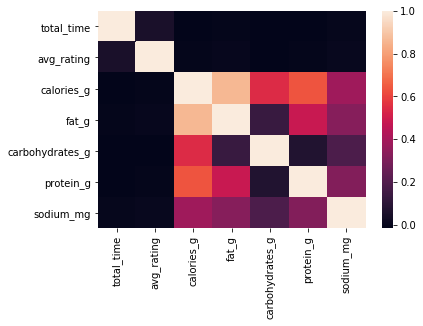

In [222]:

fig = plt.figure()
ax = plt.subplot(111)
corr = nutfacts.corr()
ax = sns.heatmap(corr)
plt.show()


In [276]:
import plotly.express as px
fig = px.scatter(no_outlie, x="calories_g", y="fat_g", hover_data=['name'])
fig.show()

In [267]:
nutfacts.head()

,name,total_time,avg_rating,calories_g,fat_g,carbohydrates_g,protein_g,cholesterol_mg,sodium_mg
0,World's Best Lasagna,195.0,4.80,448.0,21.3,36.5,29.7,82,1400.0
1,Pork Chops in Garlic Mushroom Sauce,30.0,4.61,199.0,13.4,3.1,16.3,54,333.0
2,Super Duper Slow Cooker Beef Stroganoff,435.0,4.63,394.0,24.2,14.3,26.3,97,629.0
3,Chef John's Perfect Prime Rib,390.0,4.77,1757.0,160.6,1.0,72.5,362,343.0
4,Beef Stroganoff for Instant Pot®,62.0,4.46,536.0,26.2,45.2,29.0,121,1312.0


In [275]:
no_outlie = nutfacts.loc[nutfacts['calories_g'] < 2000]

In [273]:
nutfacts.iloc[5335:5341]

,name,total_time,avg_rating,calories_g,fat_g,carbohydrates_g,protein_g,cholesterol_mg,sodium_mg
5335,Penne a la Vodka I,0.0,4.48,462.0,22.2,43.9,19.9,52,1028.0
5336,Cavatini I,0.0,4.57,360.0,17.7,39.0,23.6,49,307.0
5337,Chicken a la King II,0.0,4.08,228.0,10.5,11.7,21.2,112,175.0
5338,Chicken Bake and Rice,0.0,4.24,4709.0,383.9,32.6,273.2,980,22099.0
5339,Calamari in Red Wine and Tomato Sauce,0.0,4.09,576.0,42.0,3.0,42.1,127,2963.0
5340,Onion Spaghetti,40.0,4.35,624.0,46.1,16.5,26.8,93,1837.0


### More Recommendations

In [232]:
from math import e

class RatingExtractor:
    def __init__(self):
        print("rating initialized")

    # Version-4

    #Returns overall rating score
    #Parameters:
        #r: indicates the rating for the destination
        #rc: rating count
        #pf: positive feedback count
        #bf: negative feedback count
    @staticmethod
    def get_rating_weight_with_count_and_reviews(r, rc, pf, bf):
        if r > 10 or r < 0:
            return None
        else:
            positive_diff = (10 - r) / 2
            positive_rating = r + positive_diff

            negative_diff = r / 2
            negative_rating = r - negative_diff

            updated_rating = ((r * rc) + (pf * positive_rating) + (bf * negative_rating)) / (rc + pf + bf)

            return RatingExtractor.get_rating_weight_with_quantity(updated_rating,rc,1000000,100)

In [230]:
import re, math
from collections import Counter

class CosineSimilarity:
    def __init__(self):
        print("Cosine Similarity initialized")

    @staticmethod
    def cosine_similarity_of(text1, text2):
        #get words first
        first = re.compile(r"[\w']+").findall(text1)
        second = re.compile(r"[\w']+").findall(text2)

        #get dictionary with each word and count.
        vector1 = Counter(first)
        vector2 = Counter(second)

        #convert vectors to set to find common words as intersection
        common = set(vector1.keys()).intersection(set(vector2.keys()))

        dot_product = 0.0

        for i in common:
            #get amount of each common word for both vectors and multiply them then add them together.
            dot_product += vector1[i] * vector2[i]

        squared_sum_vector1 = 0.0
        squared_sum_vector2 = 0.0

        #get squared sum values of word counts from each vector.
        for i in vector1.keys():
            squared_sum_vector1 += vector1[i]**2

        for i in vector2.keys():
            squared_sum_vector2 += vector2[i]**2

        #calculate magnitude with squared sums.
        magnitude = math.sqrt(squared_sum_vector1) * math.sqrt(squared_sum_vector2)

        if not magnitude:
            return 0.0
        else:
            return float(dot_product) / magnitude

In [242]:
import numpy as np
import pandas as pd
# from cosine_similarity import CosineSimilarity
import operator
import json

class RecommenderEngine:
    def __init__(self):
        print("engine initialized")

    def get_recommendations(keywords):

        df69 = df

        score_dict = {}

        for index, row in df69.iterrows():
            score_dict[index] = CosineSimilarity.cosine_similarity_of(row['ings_str'], keywords)

        #sort cities by score and index.
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        #create an empty results data frame.
        resultDF = pd.DataFrame(columns=('name', 'ings', 'rating', 'score'))

        #get highest scored 5 cities.
        for i in sorted_scores:
            #print index and score of the city.
            #print(i[0], i[1])
            resultDF = resultDF.append({'name': df69.iloc[i[0]]['name'], 'ings': df69.iloc[i[0]]['ings_str'], 'rating': df69.iloc[i[0]]['avg_rating'], 'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>4:
                break

        #convert DF to json.
        json_result = json.dumps(resultDF.to_dict('records'))
        return json_result

In [250]:
lobster_keywords = "lobster butter"
chicken_keywords = "chicken pepper oil"
veggie_keywords = "broccoli cheese pepper"

In [247]:
def get_recommendations(keywords):
    result = RecommenderEngine.get_recommendations(keywords)
    return result

def get_top_5_city_names_out_of_json(json_string):
    list = json.loads(json_string)
    result = []
    max = len(list)
    i = 0
    while i < max:
        result.append((list[i]['name'], list[i]['score']))
        i += 1

    return result

In [251]:
lobster_rec = get_recommendations(lobster_keywords)
lobster_recipes = get_top_5_city_names_out_of_json(lobster_rec)
print(lobster_recipes)

[('Steamed Lobster Tails', 0.8164965809277259), ('Easiest Oven Baked Chicken', 0.4999999999999999), ('Peanut Butter Quesadillas', 0.4999999999999999), ('Easy Cheesy Chicken II', 0.4999999999999999), ('Lobster Pasta', 0.4743416490252569)]


In [253]:
chicken_rec = get_recommendations(chicken_keywords)
chicken_recipes = get_top_5_city_names_out_of_json(chicken_rec)
print(chicken_recipes)

[('Lemon Pepper Chicken and Gravy', 0.692820323027551), ('Spicy Rapid Roast Chicken', 0.6666666666666667), ('Basic Broiled Chicken Breasts', 0.6546536707079772), ("Tina's Best BBQ Lime Chicken", 0.6405126152203486), ("Denise's Peanut Chicken", 0.6221710168382553)]


In [261]:
veggie_rec = get_recommendations(veggie_keywords)
veggie_recipes = get_top_5_city_names_out_of_json(veggie_rec)
print(veggie_recipes)

AttributeError: type object 'RecommenderEngine' has no attribute 'get_recommendations'

#### With Ratings

In [263]:
class RecommenderEngine:
    def __init__(self):
        print("engine initialized")

    def calculate_final_score(cs, r):
        amount = (cs / 100) * r

        return cs + amount

    # Version-2
    def get_recommendations_include_rating(keywords):
        df69 = df

        score_dict = {}

        for index, row in df69.iterrows():
            cs_score = CosineSimilarity.cosine_similarity_of(row['ings_str'], keywords)

            rating = row['avg_rating']
            rating_contribution = RatingExtractor.get_rating_weight(rating,10)

            final_score = RecommenderEngine.calculate_final_score(cs_score, rating_contribution)

            score_dict[index] = final_score

        #sort cities by score and index.
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        #create an empty results data frame.
        resultDF = pd.DataFrame(columns=('name', 'rating', 'ings', 'score'))

        #get highest scored 5 cities.
        for i in sorted_scores:
            #print index and score of the city.
            #print(i[0], i[1])
            resultDF = resultDF.append({'name': df69.iloc[i[0]]['name'], 'rating': df69.iloc[i[0]]['avg_rating'], 'ings': df69.iloc[i[0]]['ings_str'], 'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>4:
                break

        #convert DF to json.
        json_result = json.dumps(resultDF.to_dict('records'))
        return json_result

In [262]:
from math import e

class RatingExtractor:
    def __init__(self):
        print("rating initialized")

    #Returns value between -q and q. for rating input between 0 and 5.
    #Parameters:
        #rating: indicates the rating for the destination
        #q: indicates the percentage of rating for general score. (default is 10)
    @staticmethod
    def get_rating_weight(rating, q=10):
        if rating > 5 or rating < 0:
            return None
        else:
            m = (2*q) / 5 #5 because rating varies between 0 and 5
            b = -q
            return (m*rating) + b

In [264]:
def get_recommendations_include_rating(keywords):
    return RecommenderEngine.get_recommendations_include_rating(keywords)

In [265]:
veggie_rec = get_recommendations_include_rating(veggie_keywords)
veggie_recipes = get_top_5_city_names_out_of_json(veggie_rec)
print(veggie_recipes)

[('Creamy Potato Lasagna', 0.6375477017447401), ('Country Pasta with Mozzarella', 0.6246679501943413), ('Chicken Stuffed Baked Avocados', 0.6240001709401476), ('Convenient Vegetarian Lasagna', 0.621690769863389), ('Broccoli Noodles and Cheese Casserole', 0.6006752200648866)]


In [266]:
veggie_rec

'[{"name": "Creamy Potato Lasagna", "rating": 4.23, "ings": "Alfredo sauce milk potatoes Parmesan cheese black pepper ham frozen broccoli Swiss cheese", "score": 0.6375477017447401}, {"name": "Country Pasta with Mozzarella", "rating": 3.69, "ings": "rigatoni pasta bacon broccoli florets garlic mozzarella cheese Parmesan cheese cayenne pepper parsley", "score": 0.6246679501943413}, {"name": "Chicken Stuffed Baked Avocados", "rating": 4.52, "ings": "vocados chicken breast cream cheese tomatoes black pepper cayenne pepper Parmesan cheese", "score": 0.6240001709401476}, {"name": "Convenient Vegetarian Lasagna", "rating": 4.42, "ings": "lasagna noodles ricotta cheese eggs Parmesan cheese parsley basil black pepper to taste olive oil onion carrots green bell pepper frozen broccoli chunky-style spaghetti sauce mozzarella cheese", "score": 0.621690769863389}, {"name": "Broccoli Noodles and Cheese Casserole", "rating": 3.51, "ings": "eggs head broccoli cottage cheese Cheddar cheese", "score": 0